# Automatic Patent Classification

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use("classic")
sns.set()
from time import time

## Pre-processing...

### Importing data into pandas.DataFrame

In [3]:
### Importing data into pandas.DataFrame
os.chdir('/Users/rafaelscnunes/Documents/PESC-EDC/COS738 - Busca e Recuperação '
         'da Informação/Work3 - Automatic Patent Classification/GitHub')

# load data frame
corpora = pd.read_csv('./output/dataset_ipc_first.csv',
                sep = '|', encoding = 'latin-1')

# create ipc_level1 column with IPC first level category
categories = pd.DataFrame()
categories['ipc_level1'] = corpora.apply(lambda row: row['ipc'][0:1], axis=1)

# reducing number of rows to 5000
corpora = corpora[0:4999]
categories = categories[0:4999]

### First look on data

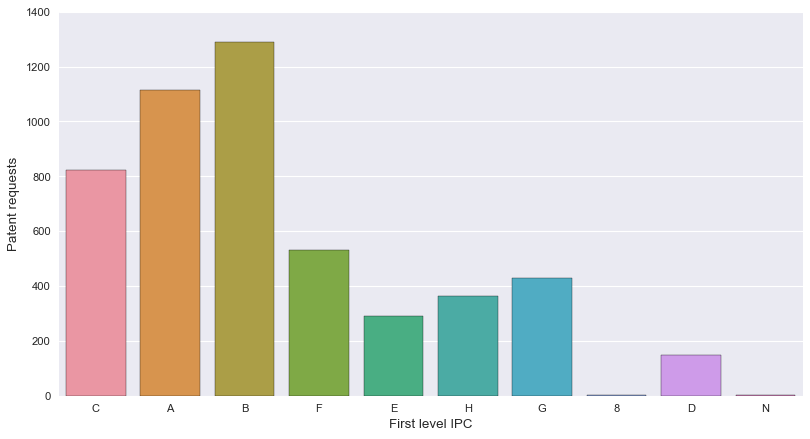

Total count of patent requests:  4999


In [4]:
### first look on data
plt.figure(figsize=(12,6))
ax = sns.countplot(x="ipc_level1", data=categories)
plt.ylabel('Patent requests', fontsize=12)
plt.xlabel('First level IPC', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()
print('Total count of patent requests: ', len(categories))

### Cleaning data frame - only IPC first level categories

In [10]:
### Cleaning data frame - only IPC first level categories

# Analysing distribution of patent requests in the 8 IPC top level categories (level 1)
values = categories.ipc_level1.value_counts().nlargest(n=8)
values.plot(kind = 'bar', colormap = 'tab20')
plt.xticks(rotation='horizontal')
print(values)
plt.show()
print('Total count on IPC first level categories (A to H): ', values.sum())

# Separating X_AH & y_AH with only IPC first level categories
corpora_AH = corpora.drop('ipc', axis=1)
corpora_AH = corpora_AH[(categories.ipc_level1 == 'A') | (categories.ipc_level1 == 'B') |
                        (categories.ipc_level1 == 'C') | (categories.ipc_level1 == 'D') |
                        (categories.ipc_level1 == 'E') | (categories.ipc_level1 == 'F') |
                        (categories.ipc_level1 == 'G') | (categories.ipc_level1 == 'H')]
categories_AH = categories[(categories.ipc_level1 == 'A') | (categories.ipc_level1 == 'B') |
                        (categories.ipc_level1 == 'C') | (categories.ipc_level1 == 'D') |
                        (categories.ipc_level1 == 'E') | (categories.ipc_level1 == 'F') |
                        (categories.ipc_level1 == 'G') | (categories.ipc_level1 == 'H')]

ValueError: Colormap tab20 is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

### Patent Requests IPC first level categories distribution

In [7]:
### Patent Request IPC first level categories distribution
plt.figure(figsize=(12,6))
ax = sns.countplot(x="ipc_level1", data=categories_AH.sort_values(by='ipc_level1', ascending=True))
plt.ylabel('Patent requests', fontsize=12)
plt.xlabel('First level IPC', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()
print('Total count on IPC first level categories (A to H): ', len(categories_AH))

NameError: name 'categories_AH' is not defined

## Extracting features...

### TF-IDF Vectorizer

In [ ]:
# TF-IDF Vectorizer
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

print('Extracting tf-idf features...')
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), max_df = .95, min_df = 1)
t0 = time()
X_tfidf_title = tfidf_vectorizer.fit_transform(corpora_AH.title.values.astype('U'))
print('Title frequence matrix shape: ', X_tfidf_title.shape)
X_tfidf_resume = tfidf_vectorizer.fit_transform(corpora_AH.resume.values.astype('U'))
print('Resume frequence matrix shape: ', X_tfidf_resume.shape)
print('done in %0.3fs.' % (time() - t0))

### Reducing deminsionality with SVD

In [ ]:
### Reducing deminsionality with SVD
from sklearn.decomposition import TruncatedSVD

print('Reducing dimensionality...')
svd = TruncatedSVD(n_components = 50)
t0 = time()
X_title = svd.fit_transform(X_tfidf_title)
print('Title most relevant features matrix shape: ', X_title.shape)
X_resume = svd.fit_transform(X_tfidf_resume)
print('Resume most relevant features matrix shape: ', X_resume.shape)
print('done in %0.3fs.' % (time() - t0))